# Laplace Approximation

Las distribuciones:
$$ p(x) \alpha  e^{-x^2/2}\sigma(20x+4) \\
\sigma(x) = (1+e^{-x})^{-1}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.misc import derivative
from scipy.stats import norm
from scipy.integrate import quad,dblquad
%matplotlib inline

In [2]:
Sigmoid = lambda x: (1+np.exp(1)**(-x))**-1
P = lambda x: np.exp(1)**(-(x**2)/2)*Sigmoid(20*x+4)

In [4]:
def LaplaceAproximation(Ps):
    ### Calculo de parametros
    
    Pformin = lambda x: -1*Ps(x)
    mu = minimize(Pformin,0).x
    logp = lambda x: np.log(Ps(x))
    A = -1*derivative(logp, mu, dx=1e-6,n=2)[0]
    sigma = np.sqrt(A**(-1))
    z = Ps(mu)*np.sqrt(2*np.pi*(sigma**2))
    
    ## Plot 
    x = np.linspace(-4,5,100)
    plt.plot(x,Ps(x),alpha=0.6,lw=5)
    plt.plot(x, norm.pdf(x,loc=mu, scale=sigma)*z,'r-', lw=5, alpha=0.6)

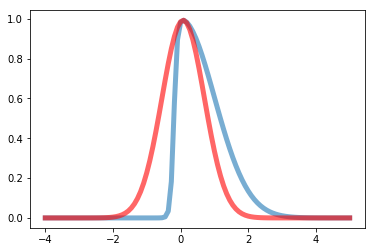

In [5]:
LaplaceAproximation(P)

# KL Reverse Divergence


In [31]:
from scipy.stats import multivariate_normal
import matplotlib.mlab as mlab


mu1 = [1,1]
cov1 =[[2,0.1],[0.1,1]]
mu2 = [8,8]
cov2 =[[2,1],[1,2]]
delta = 0.025
qcov = cov1
w=0.6

In [32]:
### Funciones 

def Comb_variables(X,Y,mu1,mu2,cov1,cov2,w):
    return w*mlab.bivariate_normal(X, Y, sigmax=cov1[0][0], sigmay=cov1[1][1], mux=mu1[0], muy=mu1[0], sigmaxy=cov1[1][0])+(1-w)*mlab.bivariate_normal(X, Y, sigmax=cov2[0][0], sigmay=cov2[1][1], mux=mu2[0], muy=mu2[0], sigmaxy=cov2[1][0])
def DevolverPuntos(z1,z2):
    points = [list(z1[0])+list(z2[0]),list(z1[1])+list(z2[1])]
    return points
def GenerarPuntos(mu1,mu2,cov1,cov2,w,delta):
    x = np.arange(-4.0, 16.0, delta)
    y = np.arange(-4.0, 16.0, delta)
    X, Y = np.meshgrid(x, y)
    z = Comb_variables(X,Y,mu1,mu2,cov1,cov2,w)
    plt.contour(X, Y, z)
    return(z)



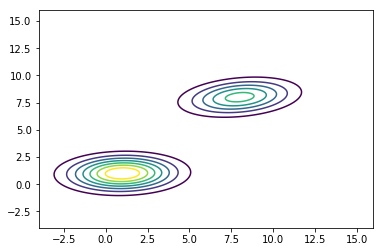

In [33]:
z = GenerarPuntos(mu1,mu2,cov1,cov2,w,delta)

In [117]:
def Q(x1,x2,mean1,mean2,cov):
    return multivariate_normal.pdf((x1,x2),mean=(mean1,mean2),cov=cov)
def P(x1,x2,mu1,mu2,cov1,cov2,w):
    return w*multivariate_normal.pdf((x1,x2),mean=mu1,cov=cov1)+(1-w)*multivariate_normal.pdf((x1,x2),mean=mu2,cov=cov2)
def IntegrandoReverse(x1,x2,qmean1,qmean2,qcov,mu1,mu2,cov1,cov2,w):
    return Q(x1,x2,qmean1,qmean2,qcov)*np.log(Q(x1,x2,qmean1,qmean2,qcov)/P(x1,x2,mu1,mu2,cov1,cov2,w))
def IntegrandoForward(x1,x2,qmean1,qmean2,qcov,mu1,mu2,cov1,cov2,w):
    return P(x1,x2,mu1,mu2,cov1,cov2,w)*np.log(P(x1,x2,mu1,mu2,cov1,cov2,w)/Q(x1,x2,qmean1,qmean2,qcov))

In [119]:
IReverse = lambda x1,x2 ,qmean1,qmean2: IntegrandoReverse(x1,x2,qmean1,qmean2,qcov,mu1,mu2,cov1,cov2,w)
IForward = lambda x1,x2, qmean1,qmean2: IntegrandoForward(x1,x2,qmean1,qmean2,qcov,mu1,mu2,cov1,cov2,w)

KLReverseTest = lambda qmean1,qmean2 : dblquad(IReverse, 0, 12, lambda x: 0, lambda x: 12,args=(qmean1,qmean2))[0]
KLReverse = (lambda qmean : KLReverseTest(qmean[0],qmean[1]))
KLForwardTest = lambda qmean1,qmean2 : dblquad(IForward, 0, 12, lambda x: 0, lambda x: 12,args=(qmean1,qmean2))[0]
KLForward = (lambda qmean : KLForwardTest(qmean[0],qmean[1]))

In [120]:
IForward(1,2,3,4)

0.073748897617093953

In [108]:
qmeanoptimo1 = minimize(KLReverse, [0,0]).x

In [121]:
qmeanoptimo2 = minimize(KLForward, [0,0]).x

In [127]:
qmeanoptimo1,qmeanoptimo2

(-1.5309554002988162, array([ 4.84000023,  4.70232533]))

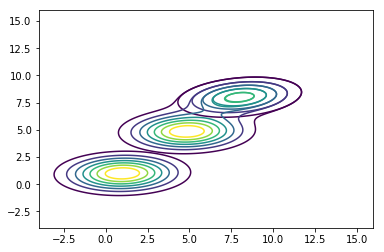

In [131]:
z = GenerarPuntos(mu1,mu2,cov1,cov2,w,delta)
z = GenerarPuntos(qmeanoptimo2,mu2,qcov,cov2,w,delta)